# Verifying ESMFold Predictions using AlphaFold2

Following submission of this manuscript and peer review, one of the reviewers made the following comment:

*"The other concern I had was the reliance of this manuscript’s methods on ESMFold, which is significantly inferior in structure prediction quality than alphafold and RoseTTAfold. This is especially concerning due to (A) the high pLDDT cutoff (70) which may filter out entire classes of encapsulins with few homologs in the UniRef databases used to train ESMFold, and (B) the relatively low size limit imposed on structure prediction (900 residues). At a minimum the authors should run alphafold or roseTTAfold on cluster representatives to demonstrate that the conclusions being presented are not artefacts of poor structure prediction."*

This is a valid concern - what if our ESMFold predictions are junk and we're jumping to erroneous conclusions as a result?

To address this point, we'll do as the reviewer suggests - we'll pick representatives from each structure cluster (as assigned using complete linkeage hierarchical clustering on the DALI distance matrix) and predict their structures with AlphaFold2, and compare those structures with the ESMFold predictions.

## Identifying Cluster Representatives

How do we choose which sequences from each cluster we're going to predict with AlphaFold2? We can't predict all ≈900 since this will take too long (which is why we used ESMFold in the first place).

Remember that we clustered the *sequences* in each structure cluster at 80% identity to reduce redundancy. Let's see how many of these reduced sequences we have:

In [1]:
from Bio import SeqIO

for i in range(17):
    infile = f"../seqs/DALI_structure_clusters/cluster_{i}.fasta_clustered_rep_seq.fasta"

    print(f"Cluster {i}")
    print(len(list(SeqIO.parse(infile, "fasta"))))

Cluster 0
3
Cluster 1
45
Cluster 2
1
Cluster 3
4
Cluster 4
44
Cluster 5
7
Cluster 6
37
Cluster 7
27
Cluster 8
56
Cluster 9
23
Cluster 10
53
Cluster 11
84
Cluster 12
11
Cluster 13
6
Cluster 14
12
Cluster 15
2
Cluster 16
25


Looks like some clusters have relatively few sequences (Clusters 0, 2, 3, 5 for example) and so for these we could feasible predict all sequences in the reduced cluster.

However some of them have way too many (10 and 11 for example).

Let's now explore whether we can pick a "cluster centre" for each cluster and choose a sequence this way instead.

First, we'll need to load the DALI distance matrix and cluster it using `scipy` as we did previously:

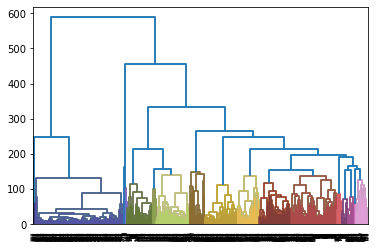

In [2]:
import numpy as np
from scipy.cluster.hierarchy import linkage, dendrogram, set_link_color_palette
import matplotlib as mpl
from matplotlib.pyplot import cm

columns = tuple(range(1, 952))
similarity_matrix = np.loadtxt("../DALI/ordered", usecols=columns, skiprows=1)

#The first 130 columns contain structures with low similarity to all the rest so I've manually removed these into their own cluster
similar_submatrix = similarity_matrix[130:, 130:]

Z = linkage(similar_submatrix, "complete")
tree = dendrogram(Z, p=5, truncate_mode="none", color_threshold=150)

cmap = cm.tab20b(np.linspace(0, 1, 16))
set_link_color_palette([mpl.colors.rgb2hex(rgb[:3]) for rgb in cmap])
tree = dendrogram(Z, p=5, truncate_mode="none", color_threshold=150)

### Cluster "Centres"

Now to choose sequences for each cluster of structures. Because we're clustering from a distance matrix we don't have a true "cluster centre" for each one. But in my mind, what makes most sense is to choose a centre for each cluster, based on distances. What I want to do is iterate through each cluster of structures, and calculate which structure has the lowest average distance to all other structures in that cluster. Not exactly a statistically rigorous way of doing it, but for demonstrating our point it should suffice.

Let's load the cluster dictionary as we did before:

In [3]:
from collections import defaultdict

cluster_dict = defaultdict(list)

for cluster, item in zip(tree["leaves_color_list"], tree["leaves"]):
    #Each cluster will be named after its colour
    cluster_dict[cluster].append(item)

for key, value in cluster_dict.items():
    print(f"{key}: {','.join([str(i) for i in value[:3]])}")

#393b79: 330,333,334
#5254a3: 336,338,335
C0: 13
#6b6ecf: 0,3,4
#637939: 186,187,188
#8ca252: 146,143,144
#b5cf6b: 163,164,161
#8c6d31: 6,29,669
#bd9e39: 621,626,613
#e7ba52: 290,291,286
#843c39: 708,709,710
#ad494a: 743,744,746
#d6616b: 761,762,771
#7b4173: 20,21,22
#a55194: 641,643,644
#ce6dbd: 328,329
#de9ed6: 249,251,252


Now, we can extract each cluster of similar structures from the similarity matrix:

In [4]:
clusters_similarity = {}

for cluster_name, cluster_members in cluster_dict.items():
    clusters_similarity[cluster_name] = similar_submatrix[np.ix_(cluster_members, cluster_members)]

clusters_similarity

{'#393b79': array([[35.5, 19.7, 19. , 17.3, 17.2],
        [19.7, 35.7, 33. , 27.1, 29.8],
        [19. , 33. , 35.5, 27.5, 30.2],
        [17.3, 27.1, 27.5, 33. , 29. ],
        [17.2, 29.8, 30.2, 29. , 33.6]]),
 '#5254a3': array([[44. , 31. , 29.2, ..., 30.9, 30.1, 30.7],
        [31. , 43.7, 29.1, ..., 32.2, 31.3, 31.5],
        [29.2, 29.1, 43.4, ..., 30. , 29.9, 30.2],
        ...,
        [30.9, 32.2, 30. , ..., 42.5, 38.6, 36.6],
        [30.1, 31.3, 29.9, ..., 38.6, 42.4, 36.9],
        [30.7, 31.5, 30.2, ..., 36.6, 36.9, 42.7]]),
 'C0': array([[36.3]]),
 '#6b6ecf': array([[50.6,  2. ,  0.1,  0.1,  0.1,  0.1],
        [ 2. , 26. , 15.7, 15.6,  0.1,  0.1],
        [ 0.1, 15.7, 29.5, 24.7,  0.1,  0.1],
        [ 0.1, 15.6, 24.7, 32.5,  0.1,  0.1],
        [ 0.1,  0.1,  0.1,  0.1, 19.8,  4.7],
        [ 0.1,  0.1,  0.1,  0.1,  4.7, 22.4]]),
 '#637939': array([[50.1, 35.3, 34.3, ..., 24.3, 23.5, 23.1],
        [35.3, 53.4, 45. , ..., 24.8, 24.4, 23.8],
        [34.3, 45. , 54.6, ..

And now finally, we can calculate the mean distance for each structure in each cluster, and print it out:

In [5]:
for cluster_name, similarities in clusters_similarity.items():
    mean_distances = np.mean(similarities, axis=1)

    centre_index = np.argmin(mean_distances)
    centre_structure_index = cluster_dict[cluster_name][centre_index]
    print(centre_structure_index)

330
335
13
1
86
139
147
669
552
274
723
730
762
14
638
329
656


Finally! These are our "centroid" structures - let's get their MGYP accessions:

In [6]:
#Load the labels into a list for reference
with open("../DALI/ordered", "r") as matrixfile:
    matrixfile.readline()
    identifiers = [line.rstrip().split()[0] for line in matrixfile]

#Load our file mapping each DALI four-letter identifier to a PDB filename
with open("../DALI/chain_id_mapping.txt", "r") as mapping_file:
    chain_mapping_dict = {line.split()[0]: line.split()[1].split("_ptm0")[0].replace(".pdb", "") for line in mapping_file}

def get_sequence_name_from_matrix_index(index):
    return(chain_mapping_dict[identifiers[index]])

for cluster_name, similarities in clusters_similarity.items():
    mean_distances = np.mean(similarities, axis=1)

    centre_index = np.argmin(mean_distances)
    centre_structure_index = cluster_dict[cluster_name][centre_index]
    print(get_sequence_name_from_matrix_index(centre_structure_index + 130)) #We need to add 130 to the index since we're using a subset of the full DALI similarity matrix

MGYP003644569838
MGYP001596099228
MGYP000593196585
MGYP003703364957
MGYP003325516961
MGYP000527898060
MGYP001775299270
MGYP000345353568
MGYP001772626497
MGYP003131547602
MGYP003131763798
MGYP003645114312
MGYP003290296536
MGYP000296441433
MGYP003221559410
MGYP001330071390
MGYP000610571525


We'll pack all of this code up into a separate script in the `scripts` directory for better readability.

## Comparing AF2 and ESMFold Predictions

Now we've predicted structures for the sequences chosen above, which are located in the `AF2_predictions` folder. We also have ESMFold predictions for these files in the `structures/confident` folder.

We've written a script `scripts/make_af2_dataframe.py` which will calculate TM-Scores and pLDDTs for all these structures and put them in a DataFrame. Let's load this data:

In [51]:
import pandas as pd

af2_df = pd.read_csv("../metadata/AF2_vs_ESMFold_predictions.csv")
af2_df.head()

,Accession,TM-Score,ESMFold pLDDT,AF2 pLDDT
0,MGYP000527898060,0.83661,77.135999,86.833011
1,MGYP003251308532,0.81644,86.536552,79.267024
2,MGYP000430909014,0.90716,84.875346,76.904364
3,MGYP001775310354,0.93801,83.593149,83.783390
4,MGYP003239287391,0.88060,74.549306,79.177630


Some of the ESMFold pLDDT values are scaled down by a factor of 100, so let's fix these:

In [52]:
def fix_plddt(plddt):
    if plddt < 1:
        return(plddt * 100)
    return(plddt)

af2_df["ESMFold pLDDT"] = af2_df["ESMFold pLDDT"].apply(fix_plddt)

We'll also merge with our structure clusters so we can label with these if necessary:

In [53]:
dali_df = pd.read_csv("../metadata/DALI_cluster_table_2.csv").rename(columns={"MGYP": "Accession"})
af2_df = af2_df.merge(dali_df, on="Accession")
af2_df.head()

,Accession,TM-Score,ESMFold pLDDT,AF2 pLDDT,Cluster,Length,mW,pI,T_maritima_T1,M_xanthus_T3,S_elongatus_T1,Q_thermotolerans_T4,Closest Match,Longest Disordered Region (pLDDT)
0,MGYP000527898060,0.83661,77.135999,86.833011,5,281,31.899270,5.425134,0.332481,0.355890,0.395577,0.395466,S_elongatus_T1,34.0
1,MGYP003251308532,0.81644,86.536552,79.267024,13,445,48.381991,5.365339,0.317136,0.330827,0.326781,0.367758,Q_thermotolerans_T4,9.0
2,MGYP000430909014,0.90716,84.875346,76.904364,14,350,39.080248,4.707542,0.283887,0.305764,0.304668,0.322418,Q_thermotolerans_T4,6.0
3,MGYP001775310354,0.93801,83.593149,83.783390,13,360,40.687942,5.740875,0.312020,0.343358,0.285012,0.380353,Q_thermotolerans_T4,7.0
4,MGYP003239287391,0.88060,74.549306,79.177630,14,337,37.046188,4.705041,0.283887,0.315789,0.294840,0.335013,Q_thermotolerans_T4,19.0


In [54]:
import plotly.graph_objects as go 

fig = go.Figure(data=go.Scatter(
    x = af2_df["ESMFold pLDDT"],
    y = af2_df["AF2 pLDDT"],
    mode="markers",
    marker=dict(
        size=16,
        color=af2_df["TM-Score"],
        colorscale="Purples",
        showscale=True,
        line_width=1,
        line_color="darkslategrey"
    ),
    showlegend=False
))

fig.add_trace(go.Scatter(
    x=np.linspace(65, 95, 100),
    y=np.linspace(65, 95, 100),
    mode="lines",
    showlegend=False,
    line_color="black"
))

fig.update_layout(
    width=1200,
    height=600,
    font=dict(size=16),
    template='plotly_white',
    xaxis_title="ESMFold pLDDT",
    yaxis_title="AlphaFold2 pLDDT"
)

fig.show()

In [46]:
af2_df.sort_values(by="TM-Score", ascending=True)

,Accession,TM-Score,ESMFold pLDDT,AF2 pLDDT
40,MGYP001772626497,0.70810,85.093815,91.210910
12,MGYP003325516961,0.72101,71.796956,82.910806
15,MGYP001301876493,0.73890,86.670260,93.005807
29,MGYP001775299270,0.73913,76.592771,82.277973
20,MGYP003143779196,0.77405,71.465043,84.621827
23,MGYP003143863407,0.80704,70.523888,84.291661
19,MGYP003131547602,0.80850,77.534621,72.741004
32,MGYP000278747826,0.80914,70.462994,87.670669
1,MGYP003251308532,0.81644,86.536552,79.267024
30,MGYP001599865821,0.82482,71.187421,83.644334


For a figure we probably want to show the following structures:

1. The bottom 5 lowest TM-Score pairs (we know the bottom one is because of a fusion domain, if the others are too then we can omit these)

2. Those two low AF2 pLDDT structures at the bottom (from cluster 14)